In [1]:
# organize imports
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt



Using TensorFlow backend.


In [2]:
# seed for reproducing same results
seed = 9
np.random.seed(seed)



# Load data and create test and training inputs and outputs

In [31]:
# filenames must be a list
def loadData(filenames, testRatio = 0.25):
    # load simple dataset
    for i, filename in enumerate(filenames):
        PATH_FILE_TRAINING3 = os.getcwd()+"/"+filename
        f = h5py.File(PATH_FILE_TRAINING3, "r")
        # split into input and output variables
        if i==0:
            X       = f["train_input_collected"].value;     
            X      = X.transpose();
            Y        = f["train_output_collected"].value;      
            Y       = Y.transpose();
        else:
            X1       = f["train_input_collected"].value;     
            X1      = X1.transpose();
            Y1        = f["train_output_collected"].value;      
            Y1       = Y1.transpose();
            X = np.vstack((X,X1))
            Y = np.vstack((Y,Y1))   
    
    # split the data into training (75%) and testing (25%)
    (X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=testRatio, random_state=seed)

    # Examine shape of data
    print(np.shape(X))
    print(np.shape(Y))
    print(np.shape(X_train))
    print(np.shape(X_test))
    print(np.shape(Y_train))
    print(np.shape(Y_test))
    return X_train, X_test, Y_train, Y_test



# Simple no obstacle dataset - small batch

In [25]:
(X_train, X_test, Y_train, Y_test) = loadData(["thirdBatch.jld2"], testRatio = 0.25)

(1671, 182)
(1671, 180)
(1253, 182)
(418, 182)
(1253, 180)
(418, 180)


In [26]:
# create the model
model = Sequential()
model.add(Dense(256, input_dim=182, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(256, init='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])



Instructions for updating:
Colocations handled automatically by placer.


In [27]:
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=5, verbose=1)

# evaluate the model
scores = model.evaluate(X_test, Y_test)

Instructions for updating:
Use tf.cast instead.
Train on 1253 samples, validate on 418 samples
Epoch 1/100
1253/1253 [==============================] - 3s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2/100
1253/1253 [==============================] - 1s 911us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 3/100
1253/1253 [==============================] - 1s 926us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 4/100
1253/1253 [==============================] - 1s 920us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 5/100
1253/1253 [==============================] - 1s 1ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 6/100
1253/1253 [==============================] - 1s 958us/step - l

1253/1253 [==============================] - 1s 517us/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 49/100
1253/1253 [==============================] - 1s 518us/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 50/100
1253/1253 [==============================] - 1s 529us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 51/100
1253/1253 [==============================] - 1s 527us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 52/100
1253/1253 [==============================] - 1s 553us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 53/100
1253/1253 [==============================] - 1s 542us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch

Epoch 97/100
1253/1253 [==============================] - 1s 608us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 98/100
1253/1253 [==============================] - 1s 642us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 99/100
1253/1253 [==============================] - 1s 596us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 100/100
418/418 [==============================] - 0s 38us/step


In [32]:
histSimple.history.keys()

dict_keys(['mean_squared_error', 'val_mean_squared_error', 'val_loss', 'loss'])

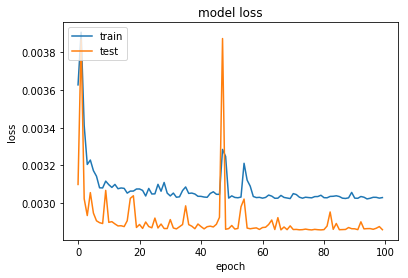

In [33]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

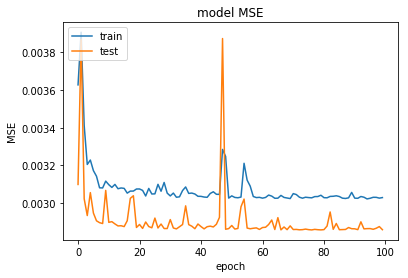

In [34]:
# summarize history for loss
plt.plot(histSimple.history['mean_squared_error'])
plt.plot(histSimple.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# No obstacle dataset - medium batch NoObstacleFirst3Iter

In [35]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3Iter.jld2"], testRatio = 0.25)

(1026, 182)
(1026, 180)
(769, 182)
(257, 182)
(769, 180)
(257, 180)


In [36]:
# create the model
model = Sequential()
model.add(Dense(256, input_dim=182, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(256, init='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])



In [37]:
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=5, verbose=1)

# evaluate the model
scores = model.evaluate(X_test, Y_test)

Train on 769 samples, validate on 257 samples
Epoch 1/100
769/769 [==============================] - 1s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 2/100
769/769 [==============================] - 1s 967us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 3/100
769/769 [==============================] - 1s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 4/100
769/769 [==============================] - 1s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 5/100
769/769 [==============================] - 1s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 6/100
769/769 [==============================] - 1s 997us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0038 - val

769/769 [==============================] - 1s 1ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 51/100
769/769 [==============================] - 1s 1ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 52/100
769/769 [==============================] - 1s 991us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 53/100
769/769 [==============================] - 1s 948us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 54/100
769/769 [==============================] - 1s 944us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 55/100
769/769 [==============================] - 1s 985us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 56/100
769/769 

Epoch 100/100
257/257 [==============================] - 0s 68us/step


In [38]:
histSimple.history.keys()

dict_keys(['mean_squared_error', 'val_mean_squared_error', 'val_loss', 'loss'])

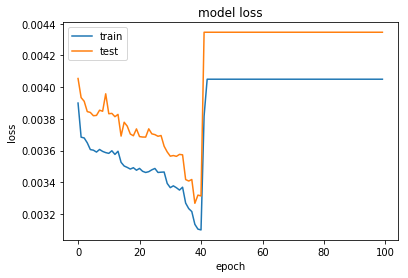

In [39]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Single obstacle dataset - medium batch SingleObstacleFirst5Iter

In [40]:
(X_train, X_test, Y_train, Y_test) = loadData(["SingleObstacleFirst5Iter.jld2"], testRatio = 0.25)

(3982, 182)
(3982, 180)
(2986, 182)
(996, 182)
(2986, 180)
(996, 180)


In [41]:
# create the model
model = Sequential()
model.add(Dense(256, input_dim=182, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(256, init='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])



In [42]:
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=5, verbose=1)

# evaluate the model
scores = model.evaluate(X_test, Y_test)

Train on 2986 samples, validate on 996 samples
Epoch 1/100
2986/2986 [==============================] - 3s 1ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 2/100
2986/2986 [==============================] - 3s 961us/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 3/100
2986/2986 [==============================] - 3s 986us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 4/100
2986/2986 [==============================] - 3s 988us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 5/100
2986/2986 [==============================] - 3s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 6/100
2986/2986 [==============================] - 3s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_los

Epoch 50/100
2986/2986 [==============================] - 2s 815us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 51/100
2986/2986 [==============================] - 2s 654us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 52/100
2986/2986 [==============================] - 2s 754us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 53/100
2986/2986 [==============================] - 2s 709us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 54/100
2986/2986 [==============================] - 2s 719us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 55/100
2986/2986 [==============================] - 4s 1ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0017 - val_mean_squared_error: 0

2986/2986 [==============================] - 4s 1ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 100/100
996/996 [==============================] - 0s 46us/step


In [43]:
histSimple.history.keys()

dict_keys(['mean_squared_error', 'val_mean_squared_error', 'val_loss', 'loss'])

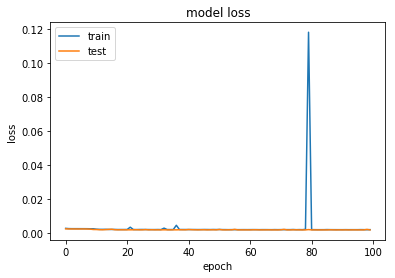

In [44]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
# save model to hdf5 file
model.save('SingleObstacleFirst5IterModel.h5') 

# Training on first and second batch

In [23]:
(X_train, X_test, Y_train, Y_test) = loadData(["firstBatch.jld2", "secondBatch.jld2"])

(5021, 182)
(5021, 180)
(3765, 182)
(1256, 182)
(3765, 180)
(1256, 180)


In [3]:
# load dataset
PATH_FILE_TRAINING1 = os.getcwd()+"/firstBatch.jld2"
PATH_FILE_TRAINING2 = os.getcwd()+"/secondBatch.jld2"

f1 = h5py.File(PATH_FILE_TRAINING1, "r")
f2 = h5py.File(PATH_FILE_TRAINING2, "r")


In [4]:
# split into input and output variables
X1       = f1["train_input_collected"].value;     
X1      = X1.transpose();
Y1        = f1["train_output_collected"].value;      
Y1       = Y1.transpose();
X2       = f2["train_input_collected"].value;     
X2      = X2.transpose();
Y2        = f2["train_output_collected"].value;      
Y2       = Y2.transpose();
X = np.vstack((X1,X2))
Y = np.vstack((Y1,Y2))

# split the data into training (75%) and testing (25%)
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.25, random_state=seed)

# Examine shape of data
print(np.shape(X))
print(np.shape(Y))
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(Y_train))
print(np.shape(Y_test))


/usr/local/lib/python3.5/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


(5021, 182)
(5021, 180)
(3765, 182)
(1256, 182)
(3765, 180)
(1256, 180)


In [5]:
# create the model
model = Sequential()
model.add(Dense(256, input_dim=182, kernel_initializer='uniform', activation='relu'))
# model.add(Dense(256, init='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(64, kernel_initializer='uniform', activation='relu'))
model.add(Dense(128, kernel_initializer='uniform', activation='relu'))
model.add(Dense(256, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])



Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# fit the model
hist = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=5, verbose=1)

# evaluate the model
scores = model.evaluate(X_test, Y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 3765 samples, validate on 1256 samples
Epoch 1/10
3765/3765 [==============================] - 6s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 2/10
3765/3765 [==============================] - 6s 2ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 3/10
3765/3765 [==============================] - 5s 1ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 4/10
3765/3765 [==============================] - 4s 1ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 5/10
3765/3765 [==============================] - 4s 1ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 6/10
3765/3765 [==============================] - 4s 1ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0023 -

In [13]:
hist.history.keys()

dict_keys(['val_loss', 'loss', 'mean_squared_error', 'val_mean_squared_error'])

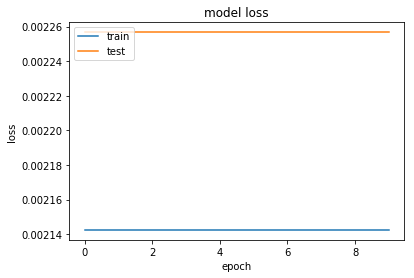

In [17]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

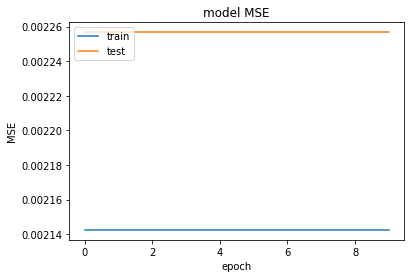

In [18]:
# summarize history for loss
plt.plot(hist.history['mean_squared_error'])
plt.plot(hist.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
Y_train[1]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.48919125e-01,  8.46208344e-02,
        0.00000000e+00,  4.06297214e-02, -1.89046252e-03,  0.00000000e+00,
        5.14810587e-01,  1.34864980e-01,  0.00000000e+00,  3.59615863e-02,
       -1.26841304e-03,  0.00000000e+00,  7.58682711e-01,  1.70820415e-01,
        0.00000000e+00,  1.21828892e-02,  6.57840457e-04,  0.00000000e+00,
        8.09750363e-01,  1.99755131e-01,  0.00000000e+00, -5.93442122e-03,
        2.66080827e-03,  0.00000000e+00,  7.27607089e-01,  2.22476637e-01,
        0.00000000e+00, -1.83903447e-02,  4.74048846e-03,  0.00000000e+00,
        5.71846436e-01,  2.39792435e-01,  0.00000000e+00, -2.51848812e-02,
        6.89688148e-03,  0.00000000e+00,  4.02061952e-01,  2.52510033e-01,
        0.00000000e+00, -2.63180303e-02,  9.12998854e-03,  0.00000000e+00,
        2.70658408e-01,  2.58752617e-01,  0.00000000e+00, -2.31556607e-02,
        1.09297866e-02,  